In [ ]:
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from data import get_data
from pinn import PINN_experiment
from modules import Model

with open("optimizers.yml", "r") as file:
    config = yaml.safe_load(file)

optimizer_names = ["Adam", "AdamW", "SGD", "RMSprop", "Adagrad", "LBFGS"]
optimizers = {name: getattr(optim, name) for name in optimizer_names} #convert them into actual optimizers

#initial neural network structure 
layers = 9
neurons = 20
activation = nn.Tanh()
noise = 0.0
iteration = 2000

results = []

for opt_name in config["optimizer"]:
    for lr in config["learning_rate"].get(opt_name, []):
        print(f"Running PINN for optimizer={opt_name}, lr={lr}")
        data = get_data()
        start_time = time.time()

        optimizer_class = optimizers[opt_name]
        optimizer_params = {"lr": lr}
        
        if opt_name == "LBFGS":
            optimizer_params.update({
                "max_iter": 2000,
                "tolerance_grad": 1e-12,
                "tolerance_change": 1e-12,
                "history_size": 50
            })

        model = Model()
        model.adam_optimizer = optimizer_class(model.network.parameters(), **optimizer_params) #the same optimizer used in pinn.py for the parameters

        PINN_experiment(data, [noise], verbose=False, rerun=True)
        all_results = np.load("./results/pinn_results.npy", allow_pickle=True)
        rmse = all_results[0][-1]
        run_time = time.time() - start_time
        results.append([opt_name, lr, rmse, run_time])

np.savez("pinn_results_new.npz", results=np.array(results, dtype=object))
print("Results saved to pinn_results_new.npz")


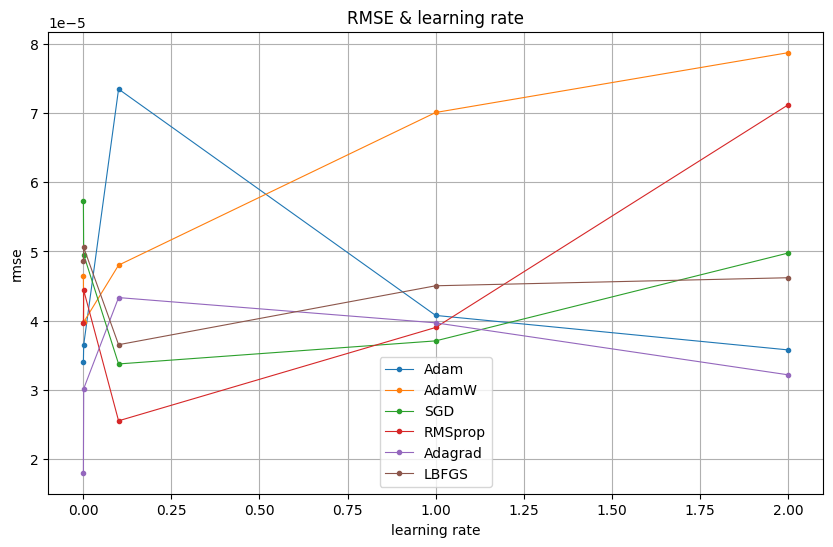

In [14]:
plt.figure(figsize=(10, 6))
for opt_name in config["optimizer"]:
    lr_values = []
    rmse_values = []
    for res in results:
        if res[0] == opt_name:
            lr_values.append(res[1])
            rmse_values.append(res[2])
    plt.plot(lr_values, rmse_values, marker='o', linestyle='-',linewidth=0.8, markersize=3, label=opt_name)

plt.xlabel("learning rate")
plt.ylabel("rmse")
plt.title("RMSE & learning rate")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
data = np.load("pinn_results_new.npz", allow_pickle=True)
results = data["results"]

best_result = min(results, key=lambda x: x[2])  

#best set of parameters --> lowest rmse
best_optimizer = best_result[0]  
best_lr = best_result[1]         
best_rmse = best_result[2]       

print(f"Best Hyperparameters:")
print(f"Optimizer: {best_optimizer}")
print(f"Learning Rate: {best_lr}")
print(f"Lowest RMSE: {best_rmse:.10f}")


Best Hyperparameters:
Optimizer: SGD
Learning Rate: 1
Lowest RMSE: 0.0000250675
